## 1. Set up

### 1 - Drive

1 - Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


2 - Move to the data folder

In [ ]:
cd "gdrive/MyDrive/Projects/1 - Numericals/Autism Prediction Challenge/2 - Production/data"

/content/gdrive/MyDrive/Projects/1 - Numericals/Autism Prediction Challenge/2 - Production/data


### 2. Libraries

In [ ]:
# Load data
import pandas as pd
import numpy as np
import io
import os
import glob

# Meta
import time

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.lines import Line2D

# Analysis
from scipy.stats import zscore

## 3. Data

1 - List file names

In [ ]:
ls

Autism-prediction/     l1_clean_encoded.csv   sample_submission.csv  train.csv
autism-prediction.zip  l1_clean_unecoded.csv  test.csv


In [ ]:
# Load sales_train in both encoded and unencoded forms

df_1 = pd.read_csv('l1_clean_encoded.csv')
df_2 = pd.read_csv('l1_clean_unecoded.csv')


## 4. Define Classes

## 5. Prepare Data

### 1 - Create an instance of the class

## 6 - Functions

In [ ]:
def create_classes(df, column_name):

  min = df[column_name].min()
  min = min - 0.5
  q1 = df[column_name].quantile(0.25)
  q2 = df[column_name].quantile(0.50)
  q3 = df[column_name].quantile(0.75)
  max = df[column_name].max()
  bin_edges = [min, q1, q2, q3, max]
  bin_names = [1,2,3,4]
  name = column_name + '_class'
  df[name] = pd.cut(df[column_name], bin_edges, labels=bin_names)
  return df


In [ ]:
def column_aggregations(df, column_name_1, column_name_2):
  
  df_copy = df.copy(deep=False)
  df_copy['total_transactions'] = df_copy.groupby([column_name_1])[column_name_2].transform('count')
  df_copy['total_sales'] = df_copy.groupby([column_name_1])[column_name_2].transform('sum')
  df_copy['avg_sales'] = df_copy.groupby([column_name_1])[column_name_2].transform('mean')
  df_1 = df_copy[[column_name_1, 'total_transactions', 'avg_sales', 'total_sales']]
  df_1 = df_1.round(2)  


  df_1 = df_1.drop_duplicates()

  df_1 = create_classes(df_1, 'avg_sales')
  df_1 = create_classes(df_1, 'total_sales')
  df_1 = create_classes(df_1, 'total_transactions')
  return df_1



In [ ]:
def aggregate_descriptive(df, column_name_1, column_name_2):
  
  # df_min
  # Agggregate features
  df_min = df.groupby([column_name_1]).agg({column_name_2:'min'})
  # Flatten dataframe
  df_min = df_min.reset_index()
  df_min.rename(columns = {column_name_2:'min_'+ column_name_2}, inplace = True)
  
  # df_max
  # Agggregate features
  df_max = df.groupby([column_name_1]).agg({column_name_2:'max'})
  # Flatten dataframe
  df_max = df_max.reset_index()
  df_max.rename(columns = {column_name_2:'max_'+ column_name_2}, inplace = True)

  # df_mean
  # Agggregate features
  df_mean = df.groupby([column_name_1]).agg({column_name_2:'mean'})
  # Flatten dataframe
  df_mean = df_mean.reset_index()
  df_mean.rename(columns = {column_name_2:'mean_'+ column_name_2}, inplace = True)

  # df_median
  # Agggregate features
  df_median = df.groupby([column_name_1]).agg({column_name_2:'median'})
  # Flatten dataframe
  df_median = df_median.reset_index()
  df_median.rename(columns = {column_name_2:'median_'+ column_name_2}, inplace = True)


  # df_sum
  # Agggregate features
  df_sum = df.groupby([column_name_1]).agg({column_name_2:'sum'})
  # Flatten dataframe
  df_sum = df_sum.reset_index()
  df_sum.rename(columns = {column_name_2:'total_'+ column_name_2}, inplace = True)


  df_1 = pd.merge(df_min, df_max, on=column_name_1)
  df_1 = pd.merge(df_1, df_mean, on=column_name_1)
  df_1 = pd.merge(df_1, df_median, on=column_name_1)
  df_1 = pd.merge(df_1, df_sum, on=column_name_1)
  df_1 = df_1.round(2)  

  return df_1



In [ ]:
def bin_num_helper(upper, lower):
    '''
    Function: Get bin size suggestions as a list
    Input: Upper and lower values. 
            Upper - Slightly higher than the maximum value of the column (51 if max is 50). Must be a whole number
            Lower - Slightly lower than the minimum value of the column (1 if min is 2). Must be a whole number
    Output: A list of bin size suggestions
    '''
    range = upper - lower
    num_range = np.arange(1,20).tolist()

    # Create a list of all values where range is divisible by numbers from 1 to 20
    divisible_num = []
    for i in num_range:
      if range%i == 0:
        divisible_num.append(i)
    print('Bin size suggestions:',divisible_num)
    print('\nOr any bin size from the range 1 to 20')



In [ ]:
def bin_num_range_selector(df, column_name):
  '''
  Function: Find the minimum and maximum values of the column
  Input: Dataframe, column name
  Output: Maximum and minimum values in the dataframe
  '''
  # Find the maximum value in the column
  maximum = df[column_name].max()
  # Find the minimum value in the column
  minimum = df[column_name].min()
  
  print('Maximum:',maximum)
  print('Minimum:',minimum)


In [ ]:
def histogram(df, column_name, n_bin):
  '''
  Function: Display histogram
  Input: Dataframe, column name of a numeric column and number of bins
  Output: Histogram
  '''
  n_bin = n_bin
  fig = plt.figure(figsize=(14,8))
  ax = plt.gca()
  counts, _, patches = ax.hist(df[column_name], bins=n_bin)
  for count, patch in zip(counts,patches):
      ax.annotate(str(int(count)), xy=(patch.get_x(), patch.get_height()+2))
  plt.xlabel(column_name+' bins') 
  plt.ylabel('Frequency') 
  locs, labels = plt.xticks()
  plt.setp(labels, rotation='45', horizontalalignment='right')
  title = "Frequency of "+ column_name
  ax.set_title(title, y=1.03, fontsize = 14, va = 'center', ha = 'center', weight = 'semibold')
  ax.set_ylabel("Frequency", weight = 'semibold')
  ax.set_xlabel(xlabel = column_name, weight = 'semibold')
  plt.show()

In [ ]:
def absolute_frequency(df, column_name, show_value):
  fig_dims = (14, 8)
  fig, ax = plt.subplots(figsize=fig_dims)
  sb.set_theme(style="whitegrid")


  sb.set_style("ticks",{"xtick.major.size":20,
  "ytick.major.size":20})

  ax = sb.countplot(x=df[column_name], data=df, palette = None, order = df[column_name].value_counts().index)

  locs, labels = plt.xticks()
  plt.setp(labels, rotation='45', horizontalalignment='right')
  title = "Frequency of "+column_name
  ax.set_title(title, y=1.03, fontsize = 14, va = 'center', ha = 'center', weight = 'semibold')
  ax.set_ylabel("Frequency", weight = 'semibold')
  ax.set_xlabel(xlabel = column_name, weight = 'semibold')


  if show_value == True:
    for p in ax.patches:
      ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+250))
    plt.show()
  else:
    plt.show()




In [ ]:
def correlation_heatmap(df):
  fig_dims = (18, 8)
  fig, ax = plt.subplots(figsize=fig_dims)
  sb.set_theme(style="whitegrid")
  dataplot = sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)


## 7 - Assessment

1 - Correlation matrix

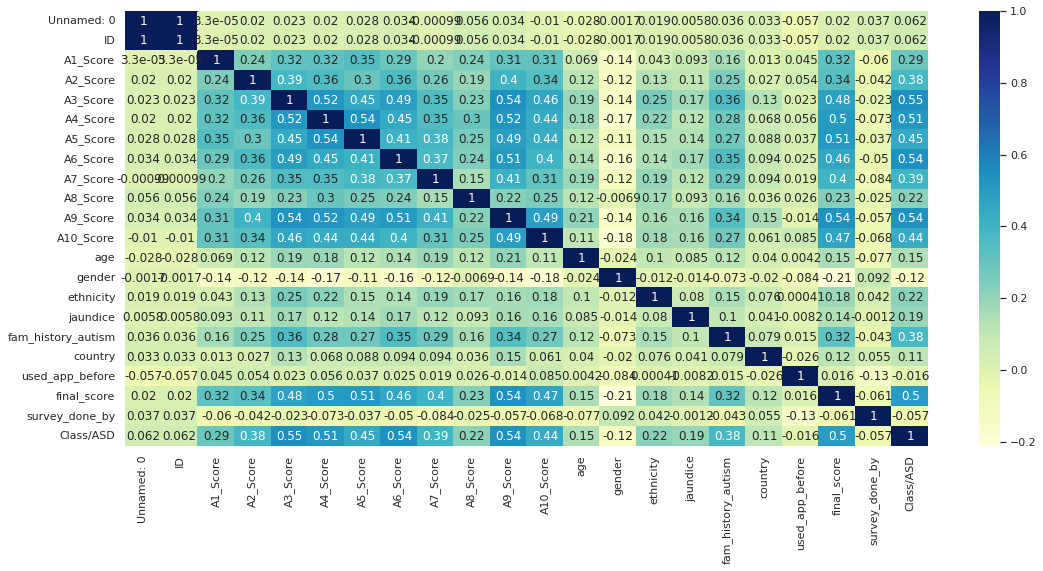

In [ ]:
correlation_heatmap(df_1)

2 - How is age distributed in the dataframe?

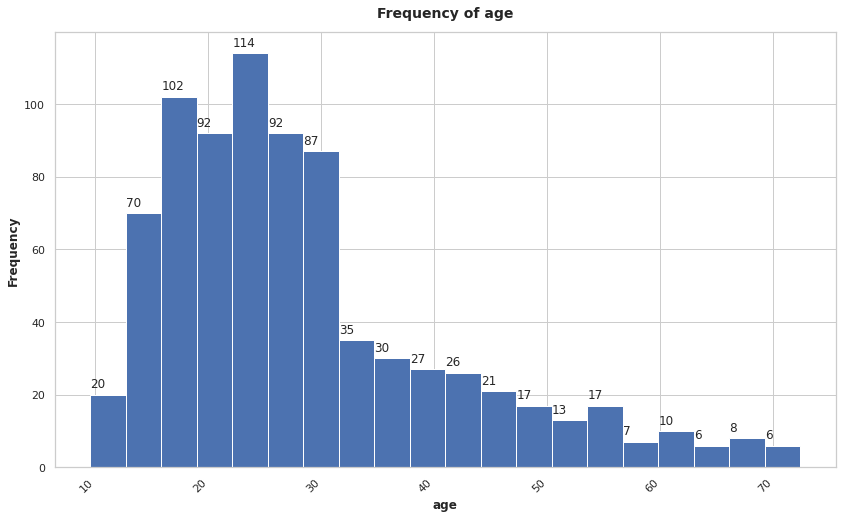

In [ ]:
# General age distribution

histogram(df_1, 'age', 20)

3. How many participants are below 18 years of age?

In [ ]:
below_18 = df_1[df_1['age'] < 18]

In [ ]:
below_18.shape

(153, 22)

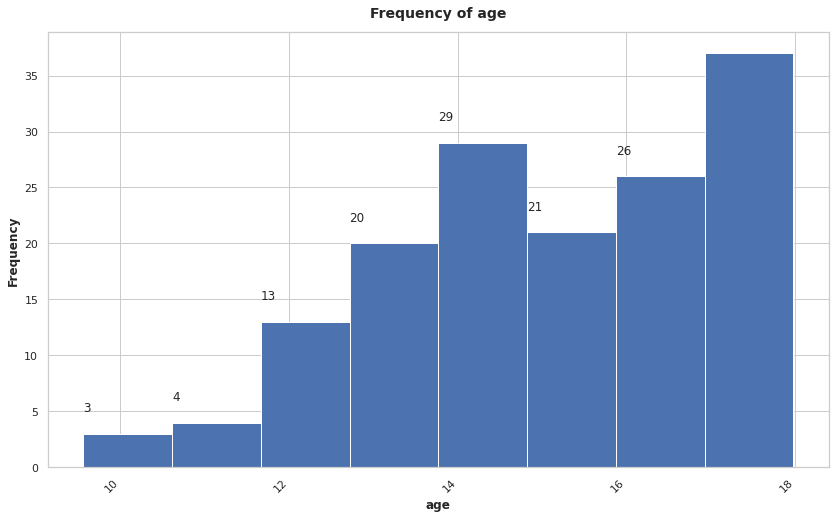

In [ ]:
histogram(below_18, 'age', 8)

4. What is the distribution of people who have taken the tests for the participants?

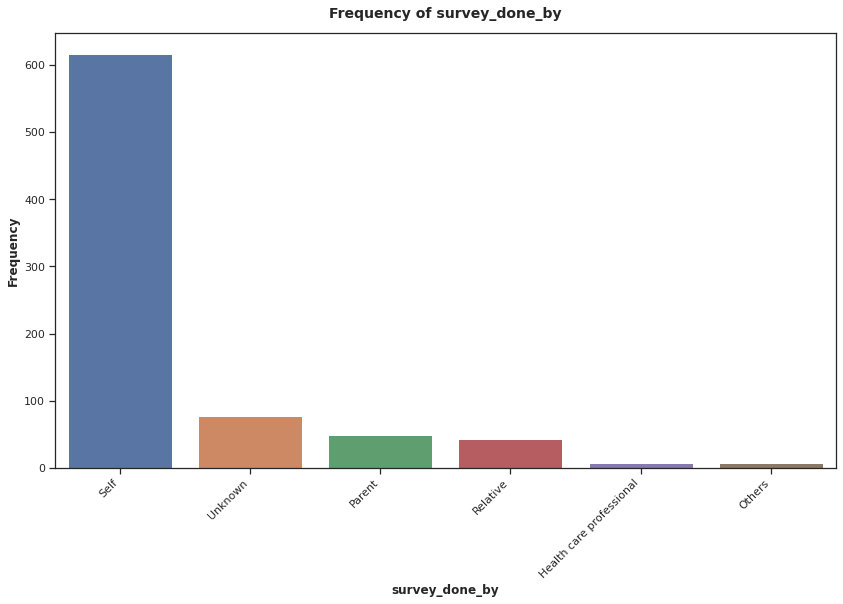

In [ ]:
absolute_frequency(df_2, 'survey_done_by', 'True')

5. What does the class balance of Class/ASD look like?

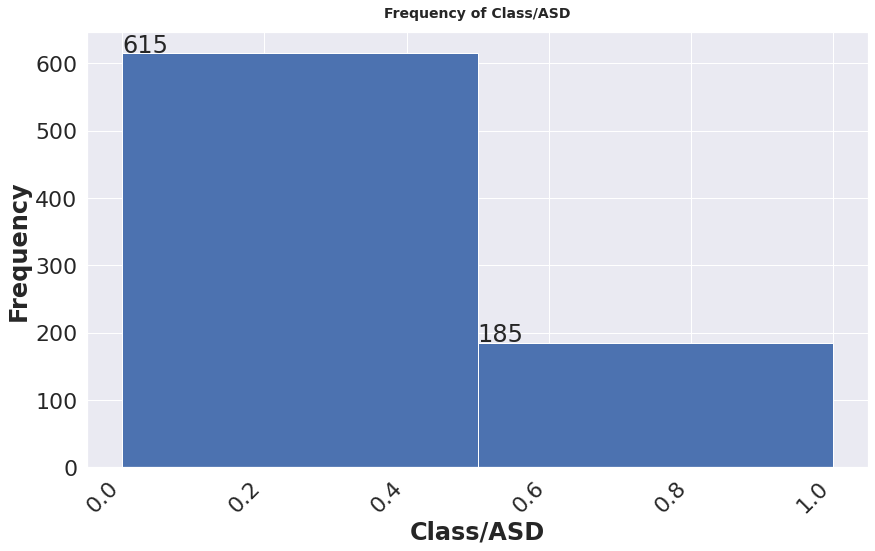

In [ ]:
histogram(df_1, 'Class/ASD', 2)

6. Divide the participants between who has taken the test for them and if they had autism

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning:

Using the countplot function without specifying `order` is likely to produce an incorrect plot.



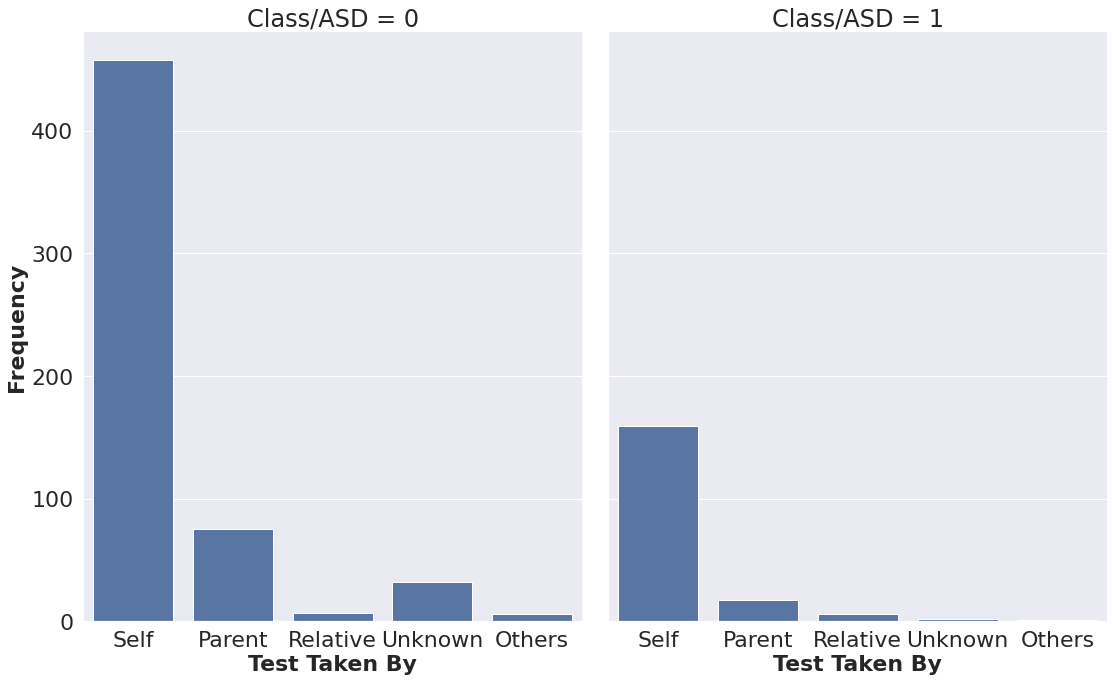

In [ ]:
# Facet by price_class
# In each, plot the barchart of categories

def annotate(data, **kws):
    n = len(data)
    ax = plt.gca()
    #ax.text(.1, .6, f"N = {n}", transform=ax.transAxes)
    title = 'Test Taken By vs. Class/ASD'
    ax.set_title(title, y=1.03, fontsize = 14, va = 'center', ha = 'center', weight = 'semibold')
    ax.set_ylabel("Frequency", weight = 'semibold', size = 22)
    ax.set_xlabel(xlabel = 'Test Taken By' , weight = 'semibold', size = 22)

sb.set(font_scale=2)
g = sb.FacetGrid(df_2, col="Class/ASD",height=10, aspect=.80)
g.map(sb.countplot, 'survey_done_by')
g.map_dataframe(annotate)



7. Age vs. survey_done_by

Text(0.5, 0, 'Test Taken By')

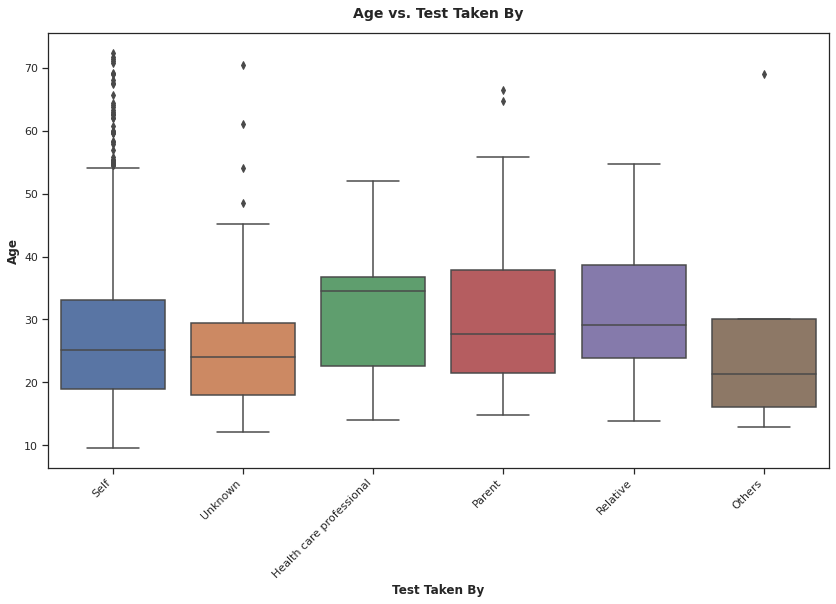

In [ ]:
fig_dims = (14, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sb.set_theme(style="whitegrid")

sb.set_style("ticks",{"xtick.major.size":20,
"ytick.major.size":20})
ax = sb.boxplot(x=df_2['survey_done_by'], y=df_2['age'], data=df_2)

locs, labels = plt.xticks()
plt.setp(labels, rotation='45', horizontalalignment='right')
title = "Age vs. Test Taken By"
ax.set_title(title, y=1.03, fontsize = 14, va = 'center', ha = 'center', weight = 'semibold')
ax.set_ylabel("Age", weight = 'semibold')
ax.set_xlabel(xlabel = 'Test Taken By', weight = 'semibold')


8. What does the plot of final_scores look like?

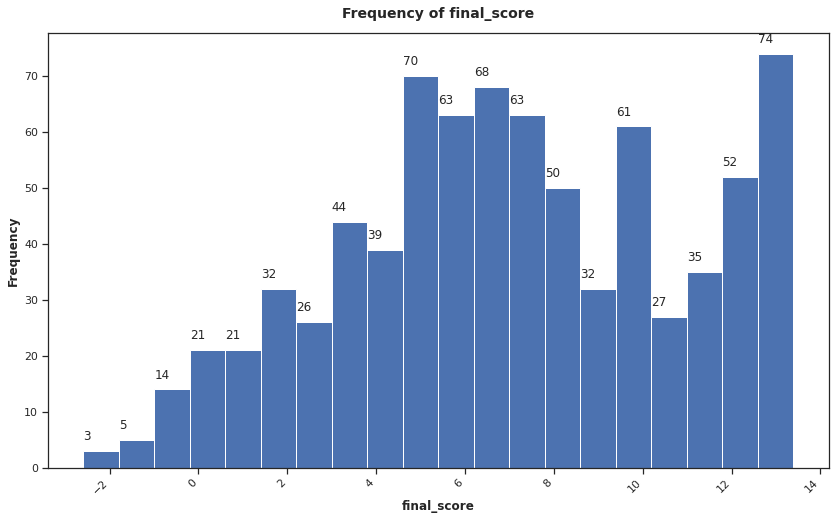

In [ ]:
histogram(df_1, 'final_score', 20)

9. How are final scores distributed over the two classes?

Text(0.5, 0, 'Class/ASD')

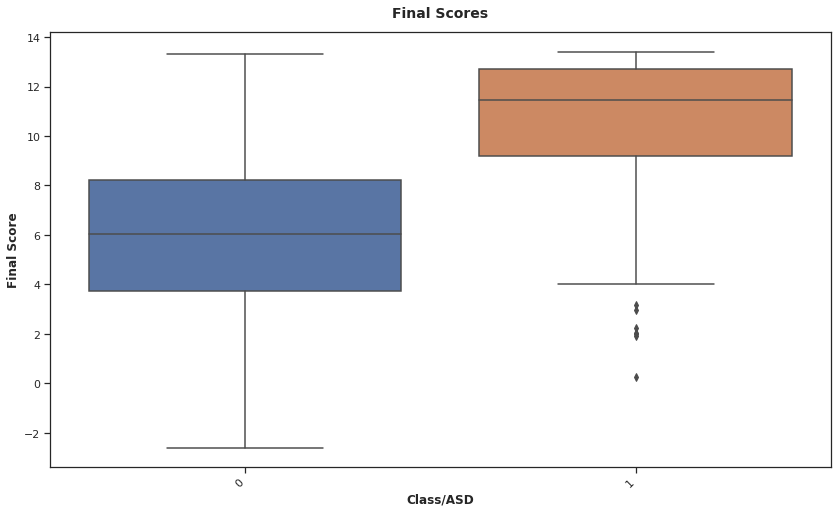

In [ ]:
fig_dims = (14, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sb.set_theme(style="whitegrid")

sb.set_style("ticks",{"xtick.major.size":20,
"ytick.major.size":20})
ax = sb.boxplot(x=df_2['Class/ASD'], y=df_2['final_score'], data=df_2)

locs, labels = plt.xticks()
plt.setp(labels, rotation='45', horizontalalignment='right')
title = "Final Scores"
ax.set_title(title, y=1.03, fontsize = 14, va = 'center', ha = 'center', weight = 'semibold')
ax.set_ylabel("Final Score", weight = 'semibold')
ax.set_xlabel(xlabel = 'Class/ASD', weight = 'semibold')


10. How many participants have a family history of autism?

---



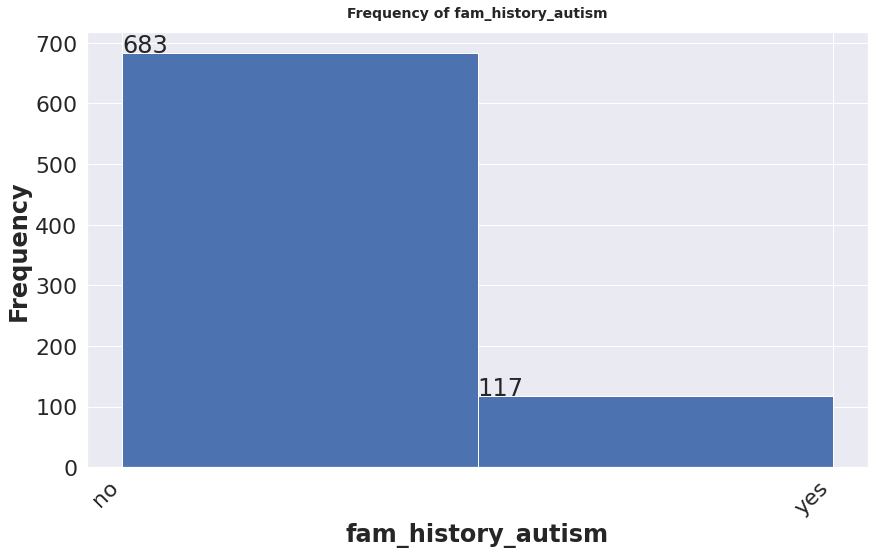

In [ ]:
histogram(df_2, 'fam_history_autism', 2)

10. When there is a family history of autism, people could be concerned about its inheritance. Of all the people who took the test, who took the test for people with a family history of autism? 

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning:

Using the countplot function without specifying `order` is likely to produce an incorrect plot.



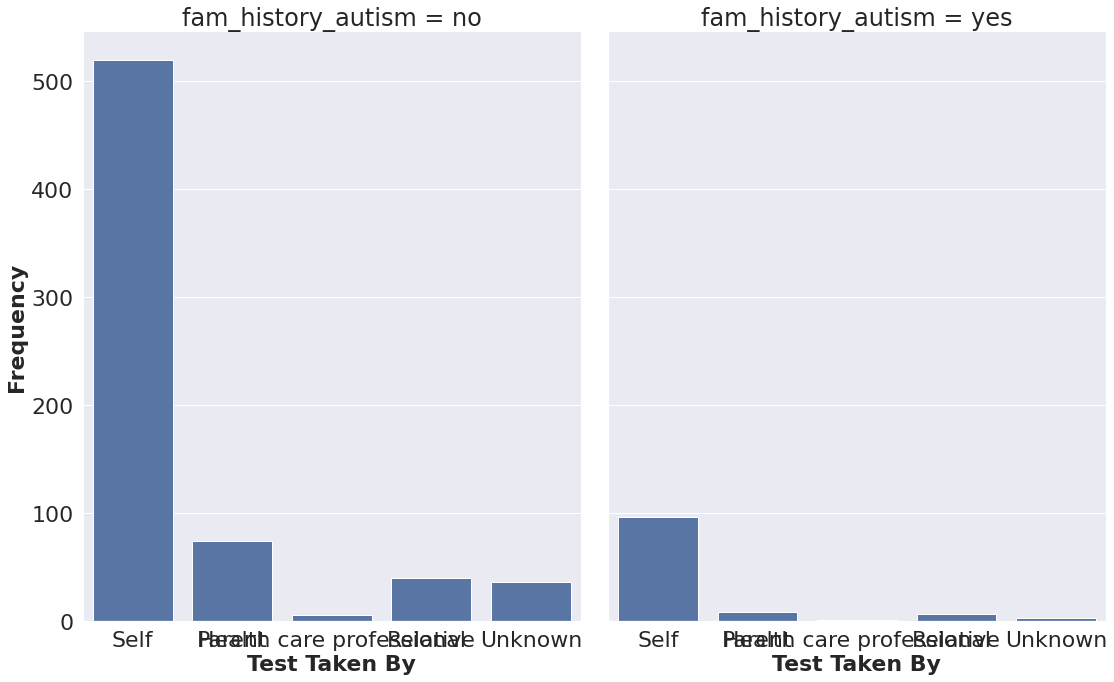

In [ ]:
# Facet by price_class
# In each, plot the barchart of categories

def annotate(data, **kws):
    n = len(data)
    ax = plt.gca()
    #ax.text(.1, .6, f"N = {n}", transform=ax.transAxes)
    title = 'Test Taken By vs. Class/ASD'
    ax.set_title(title, y=1.03, fontsize = 14, va = 'center', ha = 'center', weight = 'semibold')
    ax.set_ylabel("Frequency", weight = 'semibold', size = 22)
    ax.set_xlabel(xlabel = 'Test Taken By' , weight = 'semibold', size = 22)

sb.set(font_scale=2)
g = sb.FacetGrid(df_2, col="fam_history_autism",height=10, aspect=.80)
g.map(sb.countplot, 'survey_done_by')
g.map_dataframe(annotate)

11. How are final_scores distributed between classes with respect to family history of autism and whether they have autism or not?

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning:

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.



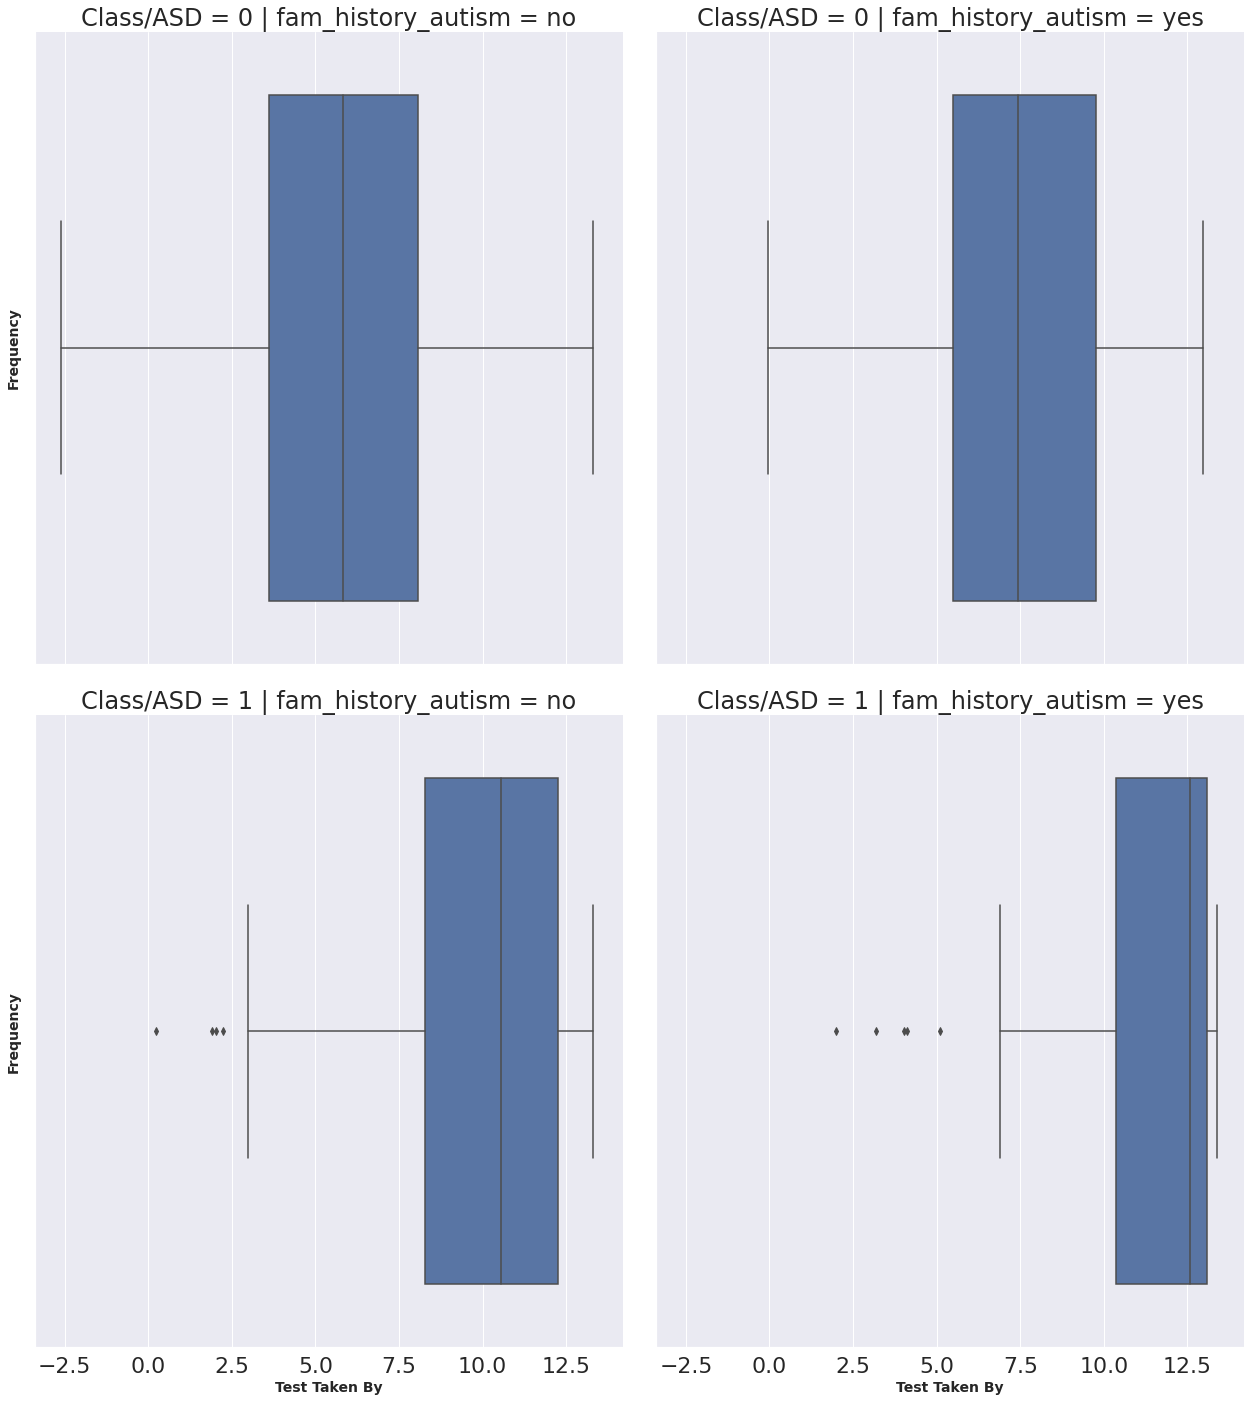

In [ ]:
# Facet by price_class
# In each, plot the barchart of categories

def annotate(data, **kws):
    n = len(data)
    ax = plt.gca()
    #ax.text(.1, .6, f"N = {n}", transform=ax.transAxes)
    title = 'Test Taken By vs. Class/ASD'
    ax.set_title(title, y=1.03, fontsize = 22, va = 'center', ha = 'center', weight = 'semibold')
    ax.set_ylabel("Frequency", weight = 'semibold', size = 14)
    ax.set_xlabel(xlabel = 'Test Taken By' , weight = 'semibold', size = 14)

sb.set(font_scale=2)
g = sb.FacetGrid(df_2, col="fam_history_autism",row='Class/ASD',height=10, aspect=.9)
g.map(sb.boxplot, 'final_score')
g.map_dataframe(annotate)

12. How is the frequency of jaundice distributed among Class/ASD?

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning:

Using the countplot function without specifying `order` is likely to produce an incorrect plot.



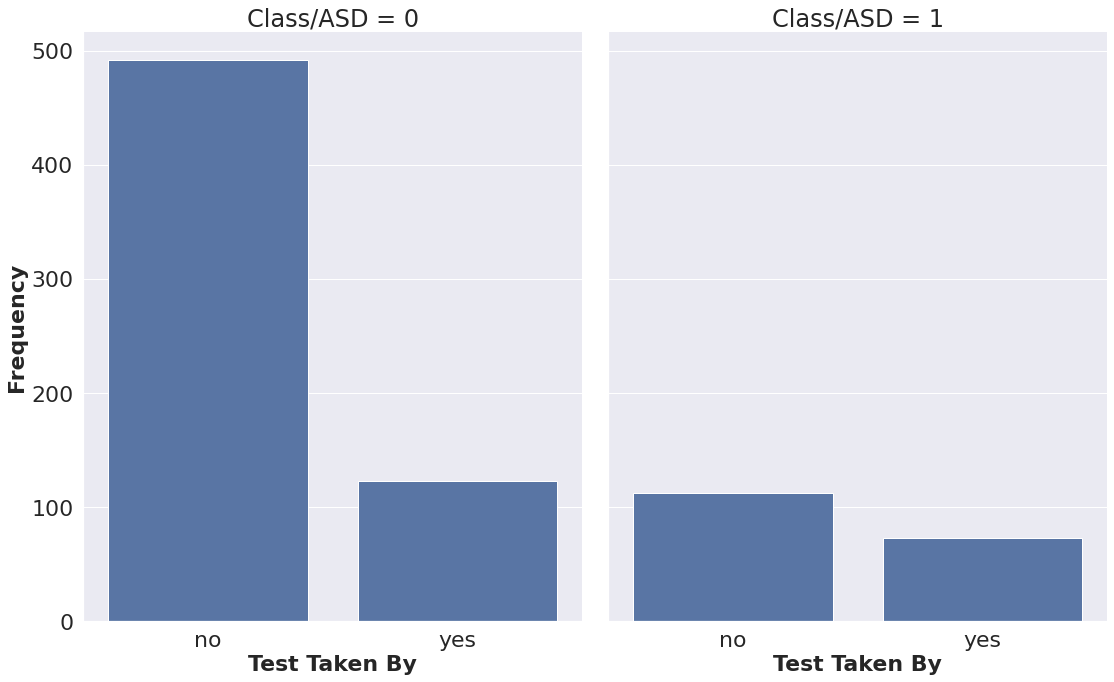

In [ ]:
# Facet by price_class
# In each, plot the barchart of categories

def annotate(data, **kws):
    n = len(data)
    ax = plt.gca()
    #ax.text(.1, .6, f"N = {n}", transform=ax.transAxes)
    title = 'Test Taken By vs. Class/ASD'
    ax.set_title(title, y=1.03, fontsize = 14, va = 'center', ha = 'center', weight = 'semibold')
    ax.set_ylabel("Frequency", weight = 'semibold', size = 22)
    ax.set_xlabel(xlabel = 'Test Taken By' , weight = 'semibold', size = 22)

sb.set(font_scale=2)
g = sb.FacetGrid(df_2, col="Class/ASD",height=10, aspect=.80)
g.map(sb.countplot, 'jaundice')
g.map_dataframe(annotate)

13. How is autism distriubuted across the age classes?

1. Add class

In [ ]:
df_2 = create_classes(df_2, 'age')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning:

Using the countplot function without specifying `order` is likely to produce an incorrect plot.



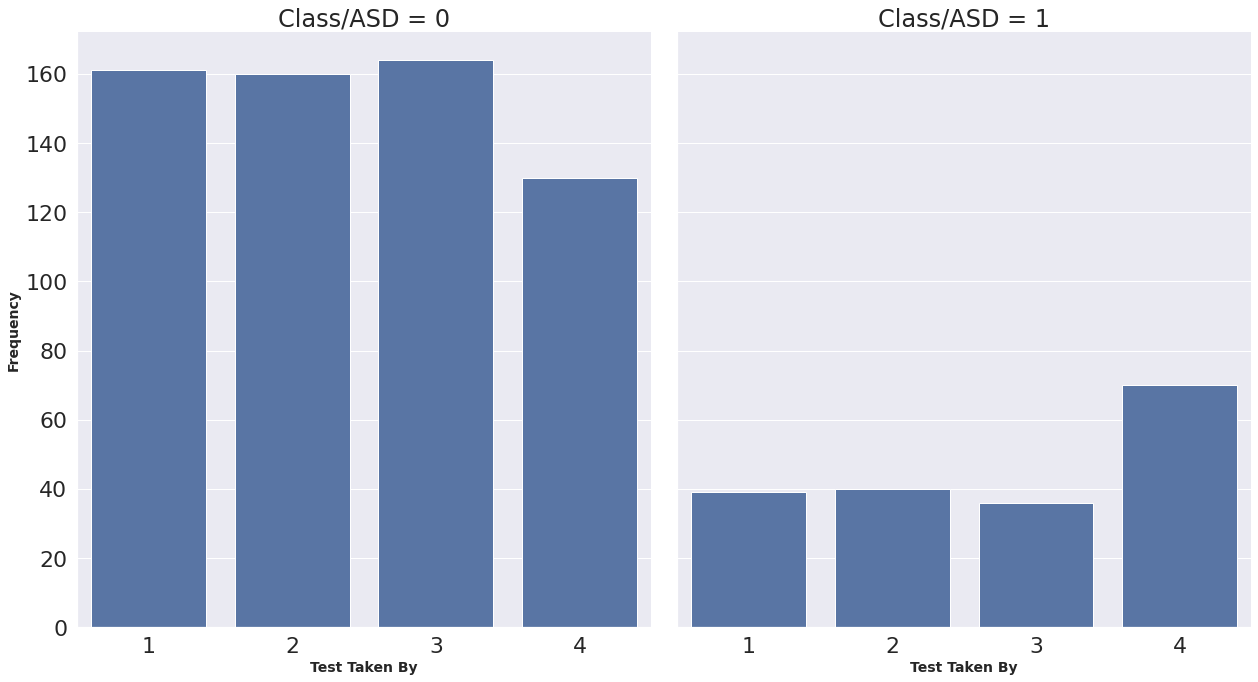

In [ ]:
# Facet by price_class
# In each, plot the barchart of categories

def annotate(data, **kws):
    n = len(data)
    ax = plt.gca()
    #ax.text(.1, .6, f"N = {n}", transform=ax.transAxes)
    title = 'Test Taken By vs. Class/ASD'
    ax.set_title(title, y=1.03, fontsize = 22, va = 'center', ha = 'center', weight = 'semibold')
    ax.set_ylabel("Frequency", weight = 'semibold', size = 14)
    ax.set_xlabel(xlabel = 'Test Taken By' , weight = 'semibold', size = 14)

sb.set(font_scale=2)
g = sb.FacetGrid(df_2, col="Class/ASD",height=10, aspect=.9)
g.map(sb.countplot, 'age_class')
g.map_dataframe(annotate)

14. Recreate correlation map

In [ ]:
def get_quantitative_lists(df):
    '''
    Function: Get the categorical column names of a dataframe 
    Input: A dataframe
    Output: The categorical and numerical column name lists
    '''

    numeric_columns = df.select_dtypes([np.number]).columns.tolist()
    columns = list(df)
    categorical_columns = []
    for i in columns:
      if i not in numeric_columns:
        categorical_columns.append(i)
      else:
        None
    
    return categorical_columns

In [ ]:
# Label Encoder
from sklearn import preprocessing

In [ ]:
# Get categorical columns as a list
category_columns = get_quantitative_lists(df_2)

In [ ]:
df_2[category_columns] = df_2[category_columns].apply(preprocessing.LabelEncoder().fit_transform)

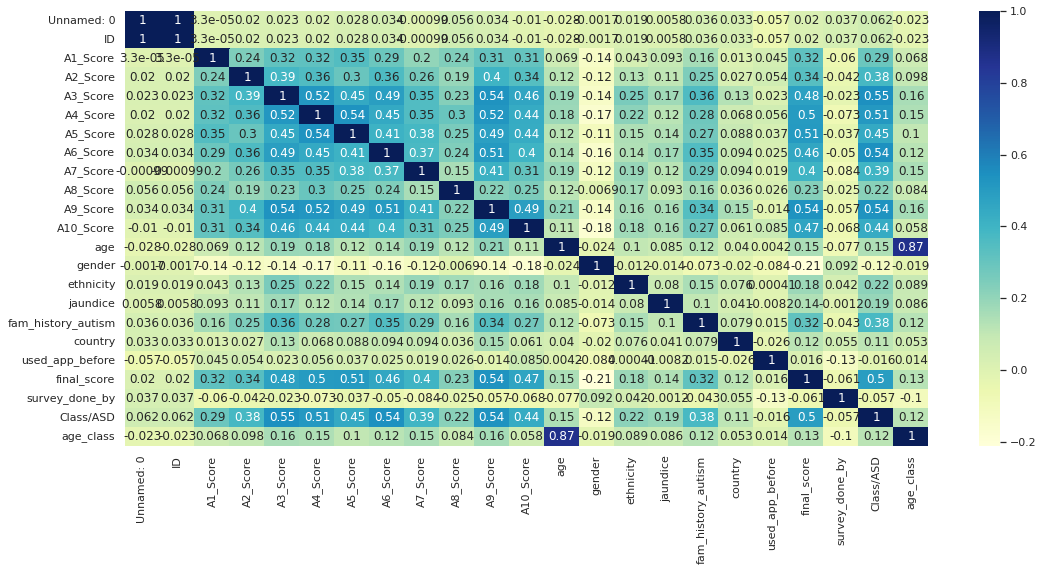

In [ ]:
correlation_heatmap(df_2)